In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
%matplotlib inline

# Pandemieausbreitung
Die Ausbreitung einer Pandemie soll am Beispiel der SARS-CoV-2 Pandemie mit dem erweiterten SIR Modell beschrieben werden. Dazu berücksichtigen wir zusätzlich zu den ansteckbaren (susceptible), infizierten (infected) und genesenen (recovered) Personen werden auch geimpfte (vaccinated) Personen berücksichtigt. Damit kann die Zeitentwicklung dieser Gruppen durch folgende gekoppelte Differentialgleichungen beschrieben werden
$$\begin{aligned}
    S'(t) &=-\frac{\beta(t)}{N} S(t) I(t)-\Gamma(t)+\delta V(t) \\
    I'(t) &=\frac{\beta(t)}{N} S(t) I(t)-\alpha I(t) \\
    R'(t) &=\alpha I(t) \\
    V'(t) &=\Gamma(t)-\delta V(t).
\end{aligned} $$
Dabei ist $N$ die Gesamtzahl der Personen, $alpha$ ist ungefähr die Inverse Zeit die infizierte Personen ansteckend sind und $R_0$ die zeitabhängige Basisreprodukutionszahl. $\beta$ ist durch das Verhältnis $\beta = R_0 \cdot \alpha$ gegeben. Für das erweiterte SIR-Modell führen wir außerdem die $\gamma(t)$ als pro Zeit geimpfte Personen ein. Damit ist $\Gamma(t) = min{\gamma(t), S(t)}$ das Minimum der ansteckbaren Personen und geimpften Personen. Schließlich ist $\delta$ die Rate in der geimpfte Personen wieder angesteckt werden können.

Das System aus gekoppelten Differentialgleichungen können wir mit dem Euler-Verfahren lösen:

In [108]:
def simulate(max_steps, dt, getBeta, getGamma, delta, sus0, inf0, rec0, vac0):
    """simulation of a pandemic using the SIR model
    
    Args:
        max_steps (int): maximum number of euler steps
        dt (float): time steps in days
        getBeta (callable): function which returns beta for a given time, suscepibility and condition
        getGamma (callable): fucntion which return gammga for a given time, susceptibility
        delta (float): delta
        sus0 (int): start value of susceptible persons
        inf0 (int): start value of infected persons
        rec0 (int): start value of recovered persons
        vac0 (int): start value of vaccinated persons
    """

    sus = np.zeros(max_steps)
    inf = np.zeros(max_steps)
    rec = np.zeros(max_steps)
    vac = np.zeros(max_steps)
    datetimes = []

    sus[0] = sus0
    inf[0] = inf0
    rec[0] = rec0
    vac[0] = vac0
    
    reachedMinInf = False

    for i in range(max_steps - 1):
        t = datetime(2021, 1, 1) + timedelta(days=(i+1)*dt)
        datetimes.append(t)
        
        # get time-dependent values beta and gamma
        # for the no Covid strategy beta also depends if the goal of a minimum of 10000
        # afftected persons is reached
        beta=getBeta(t, sus[i], reachedMinInf)
        gamma=vacGamma(getGamma(t, sus[i]), sus[i])
        
        # euler step
        sus[i+1] = sus[i] + dt * (-beta/n * sus[i] * inf[i] - gamma + delta * vac[i])
        inf[i+1] = inf[i] + dt * (beta/n * sus[i] * inf[i] - alpha * inf[i])
        rec[i+1] = rec[i] + dt * alpha * inf[i]
        vac[i+1] = vac[i] + dt * (gamma - delta * vac[i])
        
        # this is only used for no Covid strategy
        # r0 is kept at 1.2 after a minimum of 10000 afftected persons is reached
        if inf[i+1] < 10000:
            reachedMinInf = True
        
        # stop simulation if less than one person is infected
        if inf[i+1] < 1:
            break

    sus = sus[:i+1]
    inf = inf[:i+1]
    rec = rec[:i+1]
    vac = vac[:i+1]
    
    return sus, inf, rec, vac, datetimes

## Simulation für verschiede $R_0$
Zunächst simulieren wir für Reproduktionszahlen $R_0$ zwischen 1 und 20 den Anteil der Bevölkerung der nicht infiziert wird und vergleichen das mit der Herdenimmunität bei der, der Anteil mit $1/R_0$ abgeschätzt werden kann.

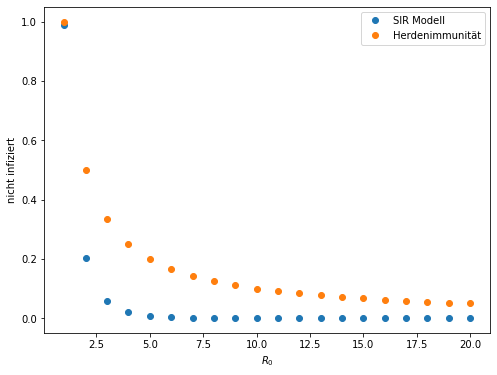

In [72]:
def constantBeta(r0):
    return lambda t, sus, goal: r0 * alpha

def constantGamma():
    return lambda t, sus: 0

def vacGamma(gamma, sus):
    return min(gamma, sus)

n = 8.3e7
alpha = 1/7

r0 = np.arange(1, 21, 1)
remaining_sus = np.zeros(20)
for i in range(20):
    remaining_sus[i] = simulate(
        max_steps=365*100, dt=0.1, getBeta=constantBeta(r0[i]), getGamma=constantGamma(),
        delta=0, sus0=n-5000, inf0=5000, rec0=0, vac0=0)[0][-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(r0, remaining_sus/n, 'o', label='SIR Modell')
ax.plot(r0, 1/r0, 'o', label='Herdenimmunität')
ax.set_xlabel('$R_0$')
ax.set_ylabel('nicht infiziert')
ax.legend()
plt.show()

Man erkennt gut, dass beim SIR-Modell ein größerer Anteil der Bevölkerung infiziert wird. Das liegt daran, dass bei der Herdenimmunität davon ausgegangen wird, dass schon am Anfang ein großer Anteil der Bevölkerung immun ist und sich damit eine Krankheit nicht so schnell ausbreitet.

## Realistische Simulation

Um den tatsächlichen Verlauf der COVID-19 Pandemie zu simulieren verwenden wir für die Anfangsbedingungen und Reproduktionszahl die Daten, die das Robert-Koch-Institut zu verfügung stellt https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen_csv.html. Und für den Anteil der geimpften Personen die Daten des Impfdashboards https://impfdashboard.de/daten.  

In [115]:
cov_data = pd.read_csv('Nowcasting_Zahlen_csv.csv', sep=';', decimal=',', encoding='iso-8859-1', engine='python')
cov_data['Datum'] = cov_data['Datum'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').date())

In [116]:
vac_data = pd.read_csv('germany_vaccinations_timeseries_v2.tsv', sep='\t')
vac_data['date'] = vac_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

Für die Zahl der infizierten Personen am 1.1.2021 nehmen wir an, dass man ungefähr 7 Tage ansteckend ist und zählen die Neuinfektionen zwischen dem 24.12.2020 und dem 1.1.2021. Für die Zahl der genesen Personen am 1.1.2021 ignorieren wir Todesfälle und zählen die Neuinfektionen bis zum 24.12.2020. Damit regibt sich die Zahl der ansteckbaren Personen am 1.1.2021 aus der Gesamtbevölkerung abzüglichen den infizierten, genesenen oder geimpften Personen.  

In [36]:
inf_january = cov_data.loc[(cov_data['Datum'] > date(2020, 12, 24)) & (cov_data['Datum'] < date(2021, 1, 1)), 'Schaetzer_Neuerkrankungen_ma4'].sum()
rec_january = cov_data.loc[(cov_data['Datum']) < date(2020, 12, 24), 'Schaetzer_Neuerkrankungen_ma4'].sum()
vac_january = vac_data.loc[vac_data['date'] == date(2021, 1, 1), 'dosen_zweit_differenz_zum_vortag'].values[0]
sus_january = n - rec_january - inf_january

print("Startbedingungen am 1.1.2021")
print(f"ansteckbar: {sus_january}, infiziert: {inf_january}, genesen: {rec_january}, geimpft: {vac_january}")

Startbedingungen am 1.1.2021
ansteckbar: 81240604.0, infiziert: 124127, genesen: 1635269, geimpft: 7


Für die Basisreproduktionzahl $R_0(t)$ und die Impfungen $\gamma(t)$ betrachten wir zwei Modelle. 
Ein vereinfachtes Modell bei dem wir den Verlauf der Pandemie in drei bzw. vier Phasen unterteilen:

In [67]:
def simpleBeta(t, sus, goal):
    if(t.date() < date(2021, 2, 13)):
        beta = 0.1209109
    elif(t.date() < date(2021, 3, 10)):
        beta = 0.1485441
    elif(t.date() < date(2021, 4, 16)):
        beta = 0.167162
    elif(t.date() < date(2021, 4, 28)):
        beta = 0.1428571
    else:
        beta = 0.1132363
    return beta * n / sus

In [38]:
def simpleGamma(t, cond):
    if(t.date() < date(2021, 1, 17)):
        return 0
    elif(t.date() < date(2021, 4, 25)):
        return(61000.)
    else: 
        return(128000.)

Und ein realistischeres Modell bei dem wir die tagesaktuellen Werte verwenden:

In [45]:
def realBeta(t, sus, goal):
    t_date = min(t.date(), cov_data['Datum'].values[-1])
    return cov_data.loc[cov_data['Datum'] == t_date, 'Schaetzer_7_Tage_R_Wert'].values[0] * n / sus * alpha

In [40]:
def realGamma(t, cond):
    t_date = min(t.date(), vac_data['date'].values[-1])
    return vac_data.loc[vac_data['date'] == t_date, 'dosen_zweit_differenz_zum_vortag'].values[0]

In beiden Fällen haben wir die Basisreproduktionszahl auf die Zahl der infizierbaren normiert.  
Damit können wir den Verlauf der Pandemie simulieren:

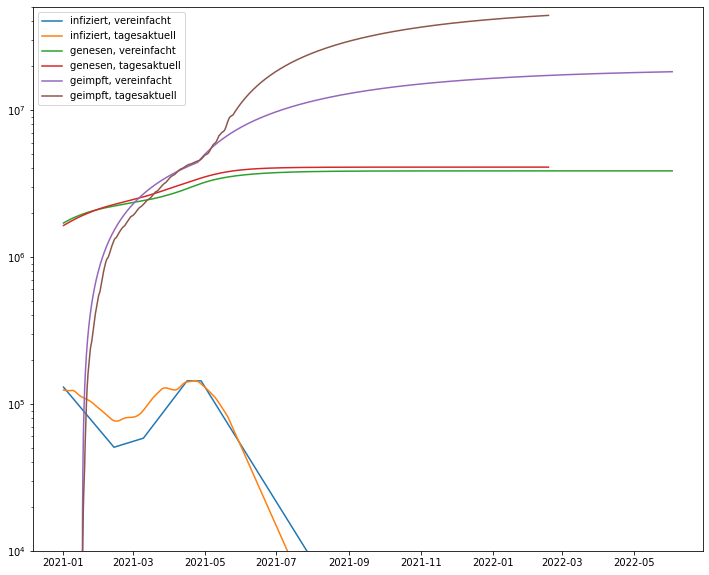

In [117]:
realSus, realInf, realRec, realVac, realDates = simulate(max_steps=365*100, dt=0.1, getBeta=realBeta, getGamma=realGamma, delta=1/150, sus0=n-inf_january-rec_january, inf0=inf_january, rec0=rec_january, vac0=0)
simpleSus, simpleInf, simpleRec, simpleVac, simpleDates = simulate(max_steps=365*100, dt=0.1, getBeta=simpleBeta, getGamma=simpleGamma, delta=1/150, sus0=n-130000-1.7e6, inf0=130000, rec0=1.7e6, vac0=0)

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(simpleDates, simpleInf, label='infiziert, vereinfacht')
ax.plot(realDates, realInf, label='infiziert, tagesaktuell')
ax.plot(simpleDates, simpleRec, label='genesen, vereinfacht')
ax.plot(realDates, realRec, label='genesen, tagesaktuell')
ax.plot(simpleDates, simpleVac, label='geimpft, vereinfacht')
ax.plot(realDates, realVac, label='geimpft, tagesaktuell')
ax.set_yscale('log')
ax.set_ylim(1e4, 5e7)
ax.legend()
plt.show()

Hier ist nochmal der Unterschied der täglichen Impfungen und der Basisreproduktionzahl für die beiden Modelle gezeigt:

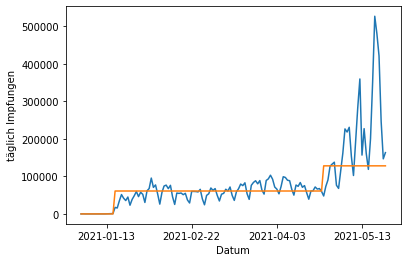

In [121]:
fig, ax = plt.subplots()
timeSeries = pd.date_range(date(2021, 1, 1), date(2021, 5, 25) - timedelta(days=1),freq='d')
ax.plot(timeSeries, [realGamma(t, None) for t in timeSeries])
ax.plot(timeSeries, [simpleGamma(t, None) for t in timeSeries])
ax.set_xlabel('Datum')
ax.set_ylabel('täglich Impfungen')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

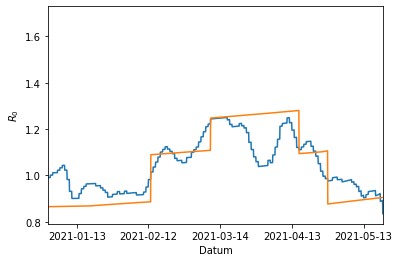

In [122]:
fig, ax = plt.subplots()
ax.plot(realDates, [realBeta(t, s, None)/alpha for t, s in zip(realDates, realSus)])
ax.plot(simpleDates, [simpleBeta(t, s, None)/alpha for t, s in zip(simpleDates, simpleSus)])
ax.set_xlabel('Datum')
ax.set_ylabel('$R_0$')
ax.set_xlim(date(2021,1,1), date(2021,5,21))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

### Abhängigkeit von der Schrittgröße
Um den Einfluss der Schrittgröße $\delta t$ auf die Infektionszahl zu untersuchen, simulieren wir die Infektionzahl nach 133 Tagen für Schrittgrößen zwischen 0.05 und 1.5

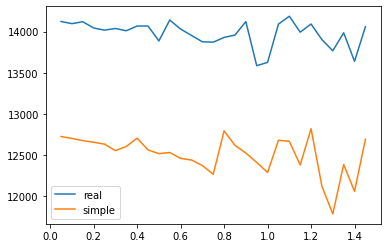

In [133]:
realInfs = []
simpleInfs = []
dts = np.arange(0.05, 1.5, 0.05)
for dt in dts:
    _, realInf, _, _, realDates = simulate(max_steps=365*100, dt=dt, getBeta=realBeta, getGamma=realGamma,
                                           delta=1/150, sus0=sus_january, inf0=inf_january, rec0=rec_january, vac0=0)
    _, simpleInf, _, _, simpleDates = simulate(max_steps=365*100, dt=dt, getBeta=simpleBeta, getGamma=simpleGamma,
                                               delta=1/150, sus0=n-130000-1.7e6, inf0=130000, rec0=1.7e6, vac0=0)
    
    # get infection after 133 days
    t = np.argmax(np.array(realDates) > datetime(2021, 1, 1, 0, 0) + timedelta(days=133))
    realInfs.append(realInf[t] / 7)
    t = np.argmax(np.array(simpleDates) > datetime(2021, 1, 1, 0, 0) + timedelta(days=133))
    simpleInfs.append(simpleInf[t] / 7)

plt.plot(dts, realInfs, label='real')
plt.plot(dts, simpleInfs, label='simple')
plt.legend()
plt.show()

Für kleine Schrittgröße $\delta t < 0.2$ ist der Unterschied sehr gering. Außerdem haben unterschiedliche Startbedingungen und die Wahl des Modells einen viel größeren Einfluss. Damit ist die Wahl einer Schrittgröße $\delta t = 0.1$ in Ordnung.

### No-COVID Strategie
Schließlich untersuchen wir ein neues Model, bei dem die Reproduktionszahl $R_0$ ab Mitte Januar solange bei 0.5 gehalten wird bis die Infektionszahl unter 10000 fällt. Anschließend wird sie bei 1.2 gehalten. Außerdem gehen wir davon aus, dass sie am Anfang Mai wegen höherer Temperaturen wieder um 80% auf 0.96 fällt.

In [ ]:
def noCovidBeta(t, sus, reachedMinInf):
    t = min(t.date(), cov_data['Datum'].values[-1])
    if t < date(2021, 1, 15):
        return cov_data.loc[cov_data['Datum'] == t, 'Schaetzer_7_Tage_R_Wert'].values[0] * n / sus * alpha
    if not reachedMinInf and t >= date(2021, 1, 15):
        return 0.5 * alpha
    if reachedMinInf and t < date(2021, 5, 1):
        return 1.2 * alpha
    if reachedMinInf and t >= date(2021, 5, 1):
        return 1.2 * 0.8 * alpha

Damit ergibt sich der folgende Verlauf bei dem es bereits Ende Oktober weniger als 100 Infizierte gibt.

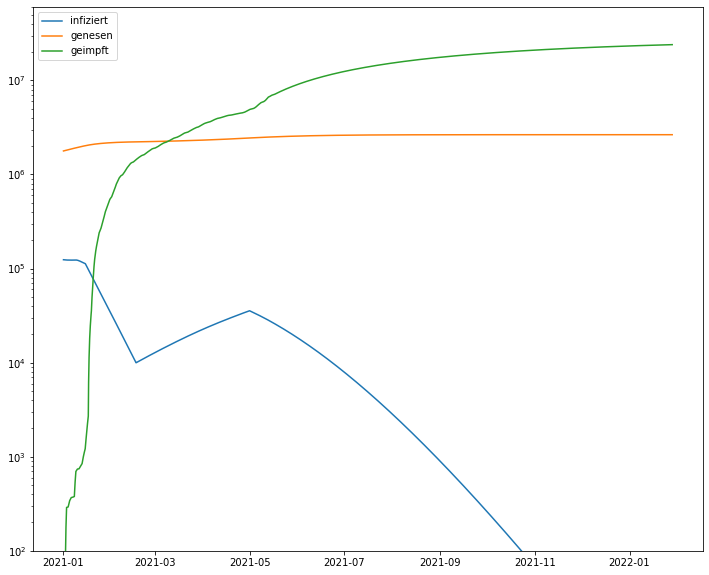

In [19]:
sus, inf, rec, vac, dates = simulate(max_steps=365*100, dt=0.1, getBeta=noCovidBeta, getGamma=realGamma, delta=1/150, sus0=n-inf_january-rec_january, inf0=inf_january, rec0=rec_january, vac0=0)
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(dates, inf, label='infiziert')
ax.plot(dates, rec, label='genesen')
ax.plot(dates, vac, label='geimpft')
ax.set_yscale('log')
ax.set_ylim(1e2, 6e7)
ax.legend()
plt.show()